In [3]:
!pip install labelme2coco


In [4]:
import labelme2coco

In [5]:
labelme_file = "/content/Assignment/Damage Identification/data/*.json"

In [6]:
save_json_path = "/content/train_annot.json"

In [7]:
labelme2coco.convert(labelme_file, save_json_path)

In [8]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ljyw5aus
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ljyw5aus
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 74 kB 3.2 MB/s 
     |████████████████████████████████| 145 kB 75.1 MB/s 
     |████████████████████████████████| 130 kB 63.4 MB/s 
     |████████████████████████████████| 749 kB 68.0 MB/s 
     |████████████████████████████████| 843 kB 60.8 MB/s 
     |████████████████████████████████| 596 kB 47.5 MB/s 
     |████████████████████████████████| 112 kB 55.5 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5350341 sha256=5041bf85737fbed7104b18203eeb5aab01648872f992a8e2ec25318eaa1f4a87
  Stored in directory: /tmp/pip-ephem-wheel-cache-xi2o65mv/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
  Created wheel for fvcore: filename=fvcore

In [9]:
!git clone https://github.com/PushpakBhoge512/Assignment.git
# Built-in imports
import os
import sys
import random

# Image processing imports
import cv2

# Machine learning imports
import numpy as np; print('NUMPY Version:{}'.format(np.__version__))
import pandas as pd; print('PANDAS Version:{}'.format(pd.__version__))
import tensorflow as tf; print('TENSORFLOW Version:{}'.format(tf.__version__))

# Visualization imports
import matplotlib.pyplot as plt

fatal: destination path 'Assignment' already exists and is not an empty directory.
NUMPY Version:1.19.5
PANDAS Version:1.1.5
TENSORFLOW Version:2.7.0


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 50

DATA_DIR = '/content/Assignment'
train_dir = os.path.join(DATA_DIR, 'Damage Identification/')
test_dir = os.path.join(DATA_DIR, 'Data Visualization/')

# Attempt at deterministic outputs(Reproducibility)
def seed_it_all(seed=7):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    #rng = np.random.default_rng(seed)
    
seed_it_all()

In [11]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    # On google colab (tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR'], pass tpu_address as param in below fn)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    #If no TPU, uncomment below to check for GPU
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [12]:
num_train_damaged = len(os.listdir(train_dir + 'images/'))
num_train_whole = len(os.listdir(train_dir + 'images/'))

print("Number of damaged train images:{}".format(num_train_damaged))
print("Number of whole train images:{}".format(num_train_whole))
print("Total train images:{}".format(num_train_damaged + num_train_whole))

print('\n')

num_test_damaged = len(os.listdir(test_dir + 'images/'))
num_test_whole = len(os.listdir(test_dir + 'images/'))

print("Number of damaged test images:{}".format(num_test_damaged))
print("Number of whole test images:{}".format(num_test_whole))
print("Total test images:{}".format(num_test_damaged + num_test_whole))

Number of damaged train images:5
Number of whole train images:5
Total train images:10


Number of damaged test images:5
Number of whole test images:5
Total test images:10


In [13]:
def display_multiple_img(image_dir, rows, cols):
    """
    Function to Display Images from Dataset.
    
    parameters: image_dir(string) - Path of directory with images
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8))
    for ind,image_path in enumerate(os.listdir(image_dir)):
        image = cv2.imread(image_dir + image_path, -1)
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_xlabel(image.shape)
        except:
            continue;
        
    plt.tight_layout()
    plt.show()

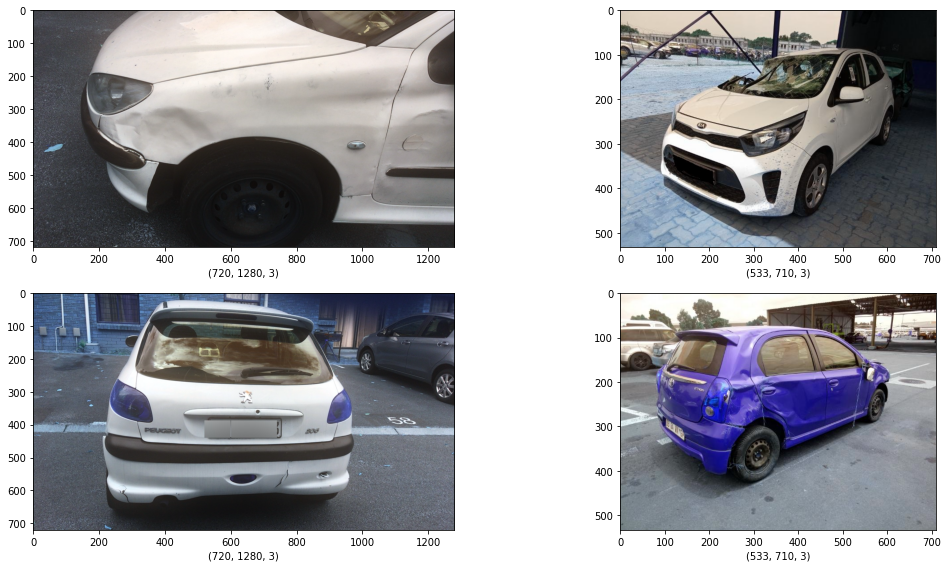

In [15]:
display_multiple_img(train_dir + 'images/', 2,2)

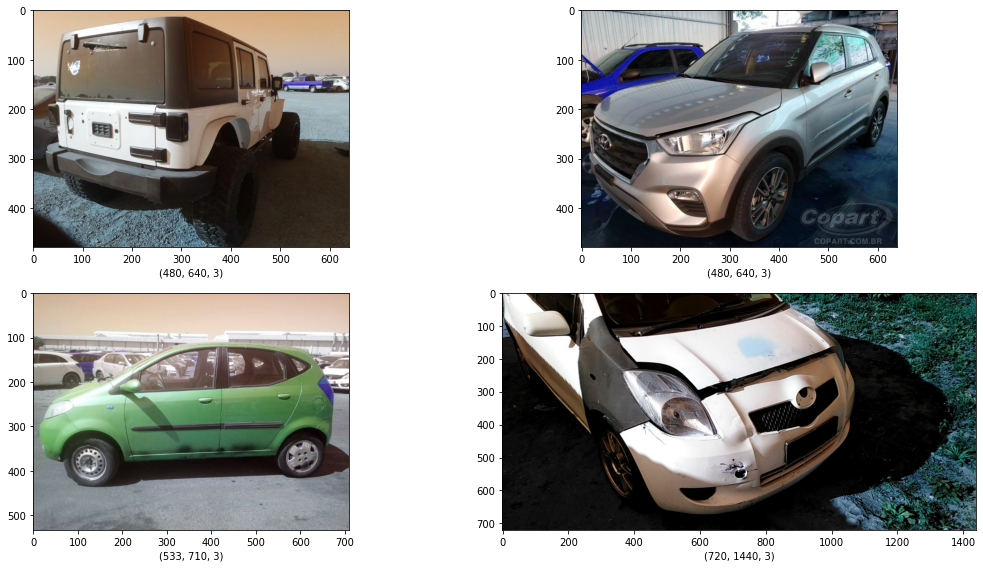

In [19]:
display_multiple_img(test_dir + 'images/', 2, 2)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/10,
                                  rotation_range=40,
                                  width_shift_range=0.4,
                                  height_shift_range=0.4,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1/10)

train_dataset = train_datagen.flow_from_directory(train_dir,
                                          target_size=(IMG_SIZE,IMG_SIZE),
                                          batch_size = BATCH_SIZE,
                                          class_mode = 'binary')
                                         
test_dataset = test_datagen.flow_from_directory(test_dir,
                                          target_size=(IMG_SIZE,IMG_SIZE),
                                          batch_size = BATCH_SIZE,
                                          class_mode = 'binary')

test_dataset.class_indices

Found 5 images belonging to 2 classes.
Found 5 images belonging to 2 classes.


{'data': 0, 'images': 1}

In [24]:
def block(x, filters, kernel_size, repetitions, pool_size=2, strides=2):
    for i in range(repetitions):
        x = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size, strides)(x)
    return x

In [25]:
def get_model():
    image_inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE , 3))
    x = block(image_inputs, 8, 3, 2)
    x = block(x, 16, 3, 2)
    x = block(x, 32, 3, 2)
    x = block(x, 64, 3, 2)
    x = block(x, 128, 3, 2)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[image_inputs], outputs=[output])
    return model

In [26]:
model = get_model()

In [27]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.001)
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1, patience=2, factor=0.2, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True,mode='max')

callbacks = [early_stopping, lr_reduction, model_checkpoint]

In [28]:
history = model.fit(train_dataset, 
                    validation_data=test_dataset,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    batch_size=BATCH_SIZE)


Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 2.3036 - accuracy: 0.0000e+00
Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to best_model.hdf5
1/1 [==============================] - 2s 2s/step - loss: 2.3036 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 00002: val_accuracy did not improve from 1.00000
1/1 [==============================] - 0s 441ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00003: val_accuracy did not improve from 1.00000
1/1 [==============================] - 0s 443ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.00

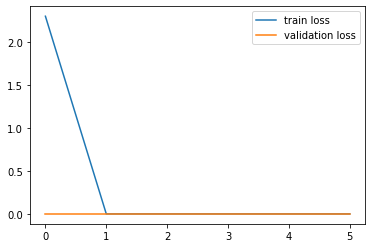

In [29]:
plt.plot(history.history['loss'], label='train loss') 
plt.plot(history.history['val_loss'], label='validation loss') 
plt.legend()
plt.show()


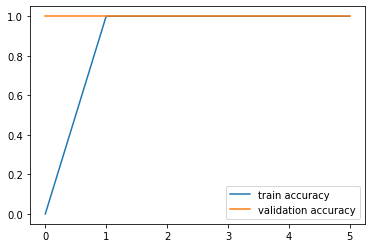

In [30]:
plt.plot(history.history['accuracy'], label='train accuracy') 
plt.plot(history.history['val_accuracy'], label='validation accuracy') 
plt.legend()
plt.show()

In [31]:


print('Validation accuracy achieved', history.history['val_accuracy'][-2])



Validation accuracy achieved 1.0


In [32]:
def predictImage(filename):
    
    img = cv2.imread(filename)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    
    Y = np.array(img)
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val < 0.5:
        plt.xlabel("Car Damaged",fontsize=30)
    elif val >= 0.5:
        plt.xlabel("Car Not Damaged",fontsize=30)

[[294.19556]]


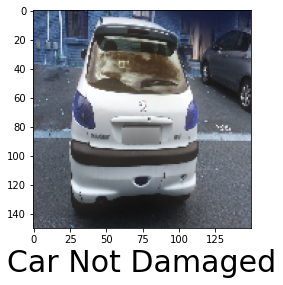

In [33]:
predictImage("/content/Assignment/Damage Identification/images/1.jpg")